In [1]:
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from keras import callbacks
from keras.models import Sequential
from keras.layers import Activation, LeakyReLU, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import Sequence
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, f1_score, ConfusionMatrixDisplay

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs:", len(gpu_devices))
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2023-02-05 19:09:12.729469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 19:09:14.041322: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/finn/anaconda3/lib/
2023-02-05 19:09:14.041403: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/finn/anaconda3/lib/
2023-02-05 19:09:14.041408: W tensorflow/compiler/tf2tensorrt/utils/py_utils

Num GPUs: 1


2023-02-05 19:09:15.995779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 19:09:16.025289: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-05 19:09:16.025344: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


Define paths

In [2]:
base_path = os.path.join("/mnt", "g", "Yerb", "guayaki")
train_path = os.path.join(base_path, "train", "labeled")
validation_path = os.path.join(base_path, "validation", "labeled")
csv_path = os.path.join("data", "files.csv")

Define all possible classes

In [3]:
classes = ["Cans", "Cans/Enlightenmint", "Cans/Revelberry", "Cans/Bluephoria", "Cans/Lemon", "Cans/Slim", "Cans/Slim/Gold", "Cans/Slim/Cranpom", "Cans/Slim/Blackberry", "Cans/Slim/Other", "Cans/Slim/GrapefruitGinger", "Cans/Slim/LimaLimon", "Cans/Other", "Bottles", "Bottles/Mint", "Bottles/Raspberry", "Bottles/Original", "Bottles/Passion", "Bottles/Other", "NoYerb"]
#classes_merged = ["Bottles", "Cans", "Cans/Slim"]
classes_merged = ["Cans", "Cans/Enlightenmint", "Cans/Revelberry", "Cans/Bluephoria", "Cans/Lemon", "Cans/Slim", "Cans/Slim/Gold", "Cans/Slim/Cranpom", "Cans/Slim/Blackberry", "Cans/Slim/Other", "Cans/Slim/GrapefruitGinger", "Cans/Slim/LimaLimon", "Cans/Other", "Bottles", "Bottles/Mint", "Bottles/Raspberry", "Bottles/Original", "Bottles/Passion", "Bottles/Other", "NoYerb"]
num_classes = len(classes)
num_classes_merged = len(classes_merged)

Define hyperparameters and input shape

In [4]:
validation_split = 0.15
img_width, img_height = 256, 256
batch_size = 64
lr = 0.0001

Perform our train/validation split

In [5]:
# Only split if our validation folder is empty (useful for retraining models)
if (len(os.listdir(validation_path)) == 0):
    for filename in os.listdir(base_path):
        # Leave folders alone
        if(filename == "train" or filename == "validation"):
            continue

        try:
            if np.random.rand() < validation_split:
                os.rename(os.path.join(base_path, filename), os.path.join(validation_path, filename))
            else:
                os.rename(os.path.join(base_path, filename), os.path.join(train_path, filename))
        except:
            pass

Assign base classes to the training data (as covered in the readme) and multi-hot encode them

In [6]:
class_list_augmented = [] # Bad global, used to pass the results to the code that calculates class weight
def generate_labels_from_csv(df):
    # Create a dictionary with the filename as the key a list of its classes as the value
    class_dict = dict(zip(df['Filename'], [label.split(',') for label in df['Label']]))

    # Create a list of the classes in the same order as the images
    class_lists = [class_dict[filename.split('\\')[-1]] for filename in df['Filename'].tolist()]
    
    # Assign base classes
    for class_list in class_lists:
        augmented_list = set(class_list)
        for label in class_list:
            if label.startswith("Cans"):
                augmented_list.add("Cans")
                if label.startswith("Cans/Slim"):
                    augmented_list.add("Cans/Slim")
            elif label.startswith("Bottles"):
                augmented_list.add("Bottles")
        class_list_augmented.append(list(augmented_list))

    # Merge classes into cans, slim cans, bottles, and no yerb
    # for class_list in class_lists:
    #     augmented_list = []
    #     for label in class_list:
    #         if label.startswith("Cans"):
    #             augmented_list.append("Cans")
    #             if label.startswith("Cans/Slim"):
    #                 augmented_list.append("Cans/Slim")
    #         elif label.startswith("Bottles"):
    #             augmented_list.append("Bottles")
    #     class_list_augmented.append(sorted(list(set(augmented_list))))

    # Convert the classes to ints
    Y = [[classes_merged.index(label) for label in image_labels] for image_labels in class_list_augmented]

    # Multi-hot encode the classes
    mlb = MultiLabelBinarizer()
    Y = mlb.fit_transform(Y)

    # Save the filenames and labels in a dictionary
    return dict(zip(df['Filename'], Y))

Define the data generator to load and normalize images in a format Keras recognises. This is used since Keras doesn't have great support for multiclass image loading

In [7]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras. Half of each batch is augmented images, the other half is the original images'
    def __init__(self, img_path, labels, batch_size=32, target_size=(512,512), n_channels=3, n_classes=10, shuffle=True):
        'Initialization'
        self.img_path = img_path
        self.img_list = os.listdir(img_path) # Usable images for training/validation
        self.labels = labels
        self.target_size = target_size
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.indices = np.arange(len(self.img_list))
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_list) / self.batch_size)*2)

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indices of the batch
        chosen_indices = self.indices[int(np.floor((index*self.batch_size/2))):int(np.floor((index+1)*self.batch_size/2))]

        # Load batch_size images and labels
        return self.__data_generation(chosen_indices)

    def on_epoch_end(self):
        'Updates indices after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indicies):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size, *self.target_size, self.n_channels))
        y = np.zeros((self.batch_size, num_classes_merged), dtype=bool)

        for image_id, it in zip(indicies, range(0, self.batch_size, 2)):
            # Read the image in as [height, width, n_channels]
            img = Image.open(os.path.join(self.img_path, self.img_list[image_id]))

            # Resize the image to the target size
            img = img.resize(self.target_size, resample=Image.BILINEAR)
            img_np = np.asarray(img)
            # Release our lock on the file (TODO: Needed?)
            img.close()
            
            # Reshape to [n_channels, height, width] if necessary
            if keras.backend.image_data_format() == 'channels_first':
                img_np = np.transpose(img_np, (2, 0, 1))

            # Normalize the image to [0,1]
            img_np = img_np / 255.

            # Apply random rotation, translation, and zoom. Use cv2
            img_aug = img_np.copy()
            img_aug = cv2.rotate(img_aug, np.random.choice([cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]))
            img_aug = cv2.warpAffine(img_aug, np.float32([[1,0,np.random.randint(-10,10)],[0,1,np.random.randint(-10,10)]]), (img_aug.shape[1], img_aug.shape[0]))
            
            X[it] = img_np
            X[it+1] = img_aug
            y[it] = self.labels[self.img_list[image_id]]
            y[it+1] = self.labels[self.img_list[image_id]]
            
        return X, y

Create train and test image generators from these classes

In [8]:
labels = generate_labels_from_csv(pd.read_csv(csv_path))
train_ds = DataGenerator(
    img_path=train_path,
    labels=labels,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True)

validation_ds = DataGenerator(
    img_path=validation_path,
    labels=labels,
    batch_size=batch_size,
    target_size=(img_width, img_height),
    shuffle=True)

Compute class weights as our dataset is very imbalanced

In [9]:
# Compute class weights
class_list_np = np.array(class_list_augmented, dtype=object)
# Collapse the list of lists into a single list
class_list_np = np.concatenate(class_list_np)

#class_weight_array = compute_class_weight(class_weight='balanced', classes=classes, y=class_list_np)
class_weight_array = compute_class_weight(class_weight='balanced', classes=classes_merged, y=class_list_np)
class_weights = dict(enumerate(class_weight_array))

Generate some samples to make sure everything matches up

KeyError: '2016-03-11_17-15-59_UTC.jpg'

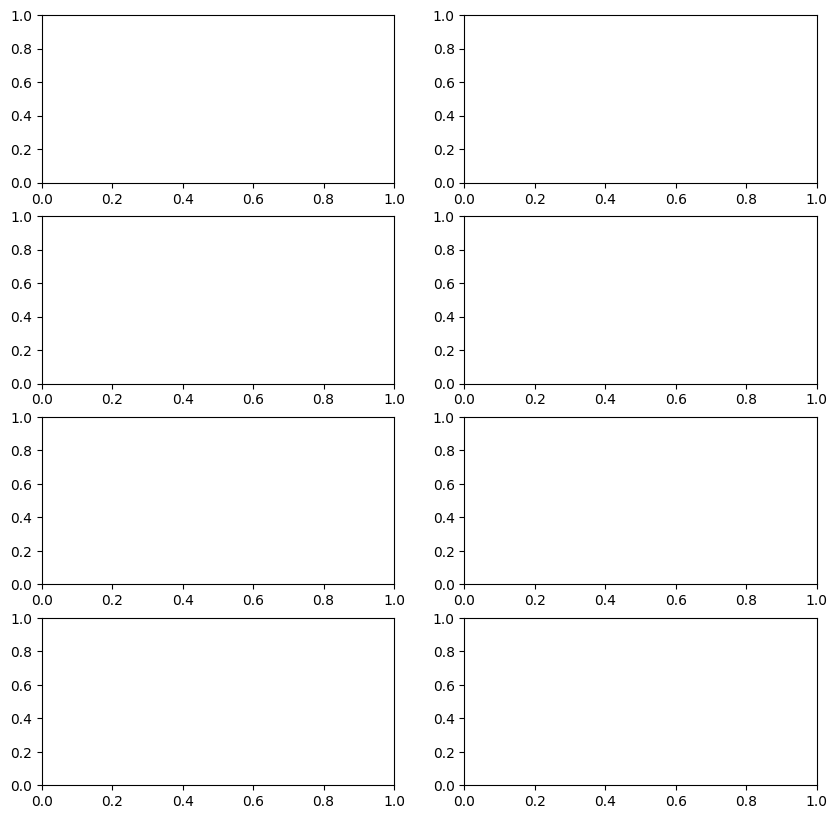

In [10]:
# Use matplotlib to print some examples from train_ds.
# Large spacing between images
fig, ax = plt.subplots(4, 2, figsize=(10, 10))
for j in range(2):
    images, labels = train_ds.__getitem__(np.random.randint(0, len(train_ds)))
    for i in range(4):
        ax[i, j].imshow(images[i])
        # Convert the one hot array back to text
        label_text = [classes_merged[u] for u, label in enumerate(labels[i]) if label == 1]
        ax[i, j].set_title(label_text)
        ax[i, j].axis('off')
plt.show()

Define the CNN. For multi-hot encoded data we use sigmoid as our final activation function instead of softmax. https://stackoverflow.com/questions/44164749/how-does-keras-handle-multilabel-classification

In [ ]:
if keras.backend.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='same'))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(num_classes_merged))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              #optimizer=SGD(lr=lr, momentum=0.9),
              optimizer=Adam(learning_rate=lr),
              #optimizer='rmsprop',
              metrics=['accuracy', 'f1_score'])


Fit using our class weights from earlier

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=15)
tensorboard = callbacks.TensorBoard(log_dir=f'./logs/run{np.random.randint(1,1000)}', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=5)
model.fit(train_ds,
        batch_size=batch_size,
        epochs=50,
        callbacks=[early_stopping, tensorboard],
        validation_data=validation_ds,
        class_weight=class_weights,
        use_multiprocessing=True)

Epoch 1/50
70/70 [==============================] - 103s 1s/step - loss: 0.5117 - accuracy: 0.3654 - val_loss: 0.5673 - val_accuracy: 0.2760
Epoch 2/50
70/70 [==============================] - 98s 1s/step - loss: 0.4619 - accuracy: 0.3763 - val_loss: 0.5470 - val_accuracy: 0.3281
Epoch 3/50
70/70 [==============================] - 105s 1s/step - loss: 0.4569 - accuracy: 0.4281 - val_loss: 0.5144 - val_accuracy: 0.5938
Epoch 4/50
70/70 [==============================] - 96s 1s/step - loss: 0.4511 - accuracy: 0.3853 - val_loss: 0.5278 - val_accuracy: 0.7161
Epoch 5/50
70/70 [==============================] - 107s 2s/step - loss: 0.4505 - accuracy: 0.4496 - val_loss: 0.5107 - val_accuracy: 0.7109
Epoch 6/50
70/70 [==============================] - 107s 2s/step - loss: 0.4385 - accuracy: 0.4801 - val_loss: 0.5079 - val_accuracy: 0.4844
Epoch 7/50
70/70 [==============================] - 98s 1s/step - loss: 0.4325 - accuracy: 0.4083 - val_loss: 0.5493 - val_accuracy: 0.2904
Epoch 8/50
70/70

KeyboardInterrupt: 

Evaluate the model (check validation set imbalance)

24/24 [==============================] - 1s 42ms/step
Class Bottles count: 82.0
Class Bottles accuracy: 0.5


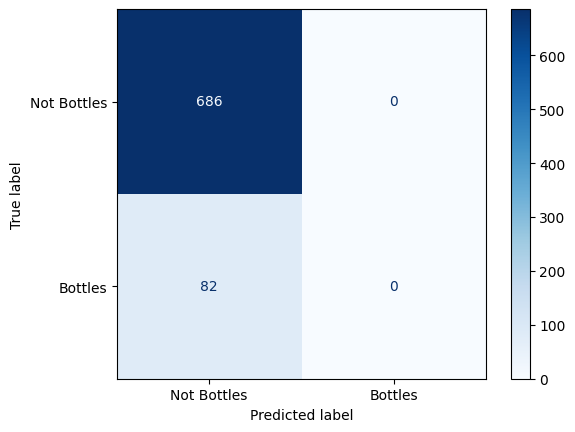

Class Cans count: 242.0
Class Cans accuracy: 0.5322722559155328


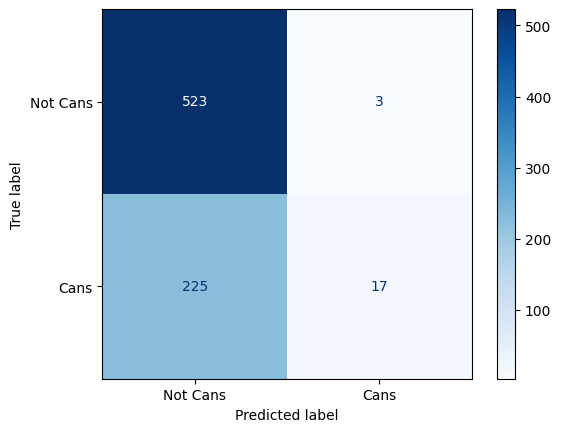

Class Cans/Slim count: 118.0
Class Cans/Slim accuracy: 0.5


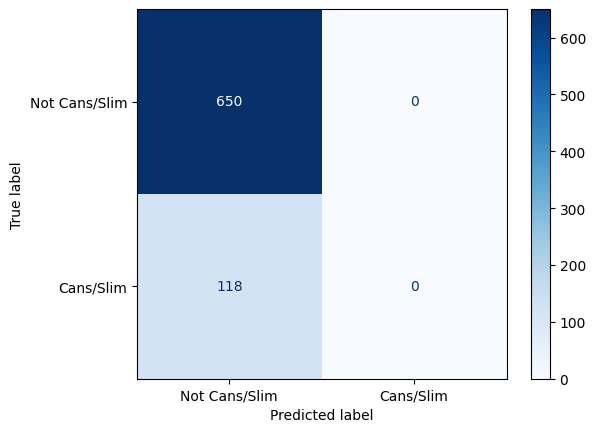

In [ ]:
# Get all validation instances into a single array
validation_images = np.empty((len(validation_ds), batch_size, img_width, img_height, 3))
validation_labels = np.empty((len(validation_ds), batch_size, num_classes_merged))
for i in range(len(validation_ds)):
    images, labels = validation_ds.__getitem__(i)
    validation_images[i] = images
    validation_labels[i] = labels
# Remove batch dimension
validation_images = np.reshape(validation_images, (len(validation_ds)*batch_size, img_width, img_height, 3))
validation_labels = np.reshape(validation_labels, (len(validation_ds)*batch_size, num_classes_merged))

# Count the number of each class in the validation set
validation_class_counts = np.sum(validation_labels, axis=0)    

class_balance = validation_class_counts/len(validation_labels)

# Create a confusion matrix
predictions = model.predict(validation_images)
predictions = np.round(predictions)

for c in classes_merged:
    print(f'Class {c} count: {validation_class_counts[classes_merged.index(c)]}')
    # ROC AUC
    print(f'Class {c} accuracy: {roc_auc_score(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist())}')
    # F1 Score
    print(f'Class {c} F1 Score: {f1_score(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist())}')

    cfm = confusion_matrix(validation_labels[:,classes_merged.index(c)].tolist(), predictions[:,classes_merged.index(c)].tolist())
    disp = ConfusionMatrixDisplay(confusion_matrix=cfm, display_labels=[f'Not {c}', c])
    disp.plot(cmap='Blues')
    plt.show()
